In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

%matplotlib inline

c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used


In [2]:
# !pip install gensim==3.0.0

In [3]:
# !pip install scipy==1.0.0

In [4]:
df = pd.read_csv("data/processed/test.csv")
df.head()
df.columns

Index(['Unnamed: 0', 'cid', 'smiles', 'action'], dtype='object')

In [5]:
import gensim
gensim.__version__

'3.0.0'

In [6]:
# remove null values
df = df[~df["action"].isnull()]

In [7]:
df['action'].value_counts()

AGONIST            108
ANTAGONIST          57
FULL AGONIST        19
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action, dtype: int64

In [8]:
def parse(x):
    x = str(x)
    if x.startswith("FULL "):
        return "AGONIST"
    else:
        return x
        
df["action_gen"] = df["action"].apply(parse)
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
POSITIVE             4
BINDER               2
NEUTRAL              2
BIASED AGONIST       2
OTHER/UNKNOWN        1
LIGAND               1
Name: action_gen, dtype: int64

In [9]:
condition = (df.action_gen != "AGONIST") & (df.action_gen != "ANTAGONIST") & (df.action_gen != "PARTIAL AGONIST")
df["action_gen"] = np.where(condition, "OTHER", df.action_gen)

In [10]:
df["action_gen"].value_counts()

AGONIST            127
ANTAGONIST          57
PARTIAL AGONIST     14
OTHER               12
Name: action_gen, dtype: int64

In [11]:
df = df.drop_duplicates(subset=['cid'])
df = df[['cid', 'smiles', 'action', 'action_gen']]
df.set_index('cid', inplace=True)
df.to_csv('data/processed/basic_data.csv')

In [12]:
df.shape

(171, 3)

In [29]:
print(">>> create mol from smiles ... ")
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model\\model_300dim2.pkl')
# w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model, unseen='UNK')]

print(">>> data columns = ", df.columns, "\n")

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)


>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['cid', 'smiles', 'action', 'action_gen', 'mol', 'sentence',
       'embedding'],
      dtype='object') 



In [30]:
df_mol2vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.760172,-4.149978,-3.370153,2.645751,1.110236,-0.118626,-11.081466,-0.428177,5.755222,2.341738,...,2.786106,11.721737,8.545668,-1.289715,-9.153688,-3.488175,-7.180833,-3.843996,-12.202745,-3.068497
1,2.212945,-1.538977,-2.224593,4.679339,1.052032,0.276928,-8.678493,2.908898,4.829803,2.057426,...,-1.862839,9.285961,7.572005,1.240420,-8.727465,-2.931877,-4.774791,-3.370778,-7.536181,-1.402127
2,-1.224218,-1.380079,-1.484625,2.016409,2.085845,-0.418231,-10.214646,0.171975,5.722785,-0.639067,...,0.040365,9.228453,8.112383,0.192953,-8.544584,-4.927303,-3.219604,-6.842189,-7.540254,-4.475022
3,1.051206,-4.003702,-2.004881,6.037580,1.132930,-0.998191,-10.552450,0.181484,8.399479,1.503116,...,-1.705281,12.330570,9.170075,1.122113,-7.963986,-2.675577,-4.884267,-4.236066,-10.162477,-1.244159
4,0.159625,-1.877022,-0.894390,4.311310,-2.904269,-0.823098,-5.099559,1.956799,5.010140,3.007601,...,0.054925,8.062354,4.741454,-0.126390,-7.416485,-2.226036,-3.864702,-2.264680,-3.720523,-1.077843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2.558320,-7.041398,-1.867085,8.540926,-1.992054,-1.297663,-11.814894,1.890232,9.369178,4.298574,...,-0.418635,14.808561,6.444794,-1.048025,-10.536049,-2.944379,-6.397175,-4.665662,-9.163932,-0.410053
167,2.268912,-6.673174,-1.812337,8.857821,-2.151901,-1.198620,-11.679358,2.329433,9.370055,4.481280,...,-0.245198,14.701890,6.460775,-1.099652,-10.371346,-2.524029,-5.959694,-5.040211,-8.999833,-0.545627
168,0.619165,-3.699804,-3.688030,1.413995,1.368354,-6.651547,-13.590994,2.757429,3.370274,2.640249,...,-2.574120,15.301981,6.480038,1.606085,-12.458905,-10.682524,-8.736527,-5.380240,-16.338335,1.824793
169,6.181717,-8.531713,-4.172251,7.466651,-0.264419,1.975113,-12.068586,-1.140604,3.199877,1.405521,...,-0.677975,15.115541,8.754032,-5.851270,-11.648660,-6.113319,-11.374367,-5.213731,-13.194325,-3.314379


In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import rand_score

In [16]:
# add indexes to dictionary
df.reset_index(inplace=True)
# encoding
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['encoded_label'] = labelencoder.fit_transform(df['action_gen'])
df

,cid,smiles,action,action_gen,mol,sentence,embedding
0,2159,CCN1CCCC1CNC(=O)C2=CC(=C(C=C2OC)N)S(=O)(=O)CC,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 225184566...","(100,) dimensional vector"
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3818546315, 848128881, 3121777292...","(100,) dimensional vector"
2,2562,CCN(CC)CCOCCOC(=O)C1(CCCC1)C2=CC=CC=C2,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 592593828...","(100,) dimensional vector"
3,3345,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 206478835...","(100,) dimensional vector"
4,3821,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,BINDER,OTHER,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3824063894, 847961216, 1733418522...","(100,) dimensional vector"
...,...,...,...,...,...,...,...
166,132990963,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=C(C=C4)F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
167,132990975,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=CC=C4F,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2968968094, 2142032900, 2968968094, 214203290...","(100,) dimensional vector"
168,134156377,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C...,AGONIST,AGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3657471097, 2092489639, 201425559...","(100,) dimensional vector"
169,137434175,CCC1=CC2=C(C(=C(N=C2C(=C1)F)N3CCC(CC3)NC4CCOCC...,ANTAGONIST,ANTAGONIST,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 618671879...","(100,) dimensional vector"


In [17]:
# scaler = StandardScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)

# scaler = MinMaxScaler()
# df_mol2vec = scaler.fit_transform(df_mol2vec)


1.000000023047832


c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


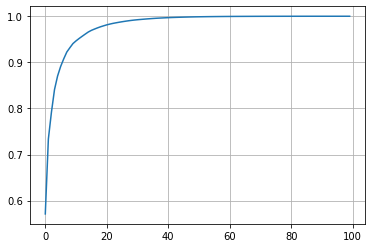

In [18]:
scaler = StandardScaler()
df_mol2vec_scaled = scaler.fit_transform(df_mol2vec)

pca = PCA().fit(df_mol2vec_scaled)
pc = pca.transform(df_mol2vec_scaled)

var = pca.explained_variance_ratio_[:10]
cum_sum = np.cumsum(pca.explained_variance_ratio_)
labels = ['PC'+ str(i) for i in range(1,11)]

print(sum(pca.explained_variance_ratio_))
# sns.barplot(labels, var)
sns.lineplot([x for x in range(len(cum_sum))], cum_sum)
plt.grid()
plt.show()

## Cluster from PC1 to PC5

In [19]:
pca_num_components = 5


reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
results = pd.DataFrame(reduced_data,columns=['pc' + str(x) for x in range(1, 6)])

# sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results)
# plt.title('Clusters on PCA with actual values')
# plt.show()


clustering_kmeans = KMeans(n_clusters=4)
results['clusters'] = clustering_kmeans.fit_predict(results)
results['clusters']

0      0
1      0
2      0
3      0
4      3
      ..
166    0
167    0
168    3
169    3
170    2
Name: clusters, Length: 171, dtype: int32

In [20]:
print(results['clusters'].value_counts())
cluster_dict = dict(results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

results['action_gen'] = df['action_gen']
results['action_gen_cluster'] = results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'ANTAGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(results.action_gen, results.action_gen_cluster))
results[results.action_gen == results.action_gen_cluster].shape[0] / results.shape[0]
print('Accuracy', results[results.action_gen == results.action_gen_cluster].shape[0] / results.shape[0])

0    78
3    74
2    14
1     5
Name: clusters, dtype: int64
pairing_score:  0.5314069487444101
Accuracy 0.5555555555555556


## PCA before clusters (PC1 & PC2)

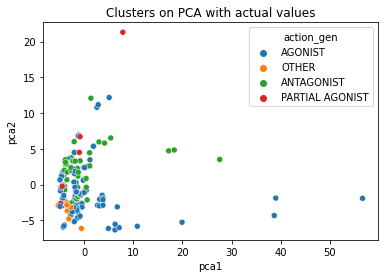

In [21]:
pca_num_components = 2


reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec_scaled)
results2 = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results2)
plt.title('Clusters on PCA with actual values')
plt.show()


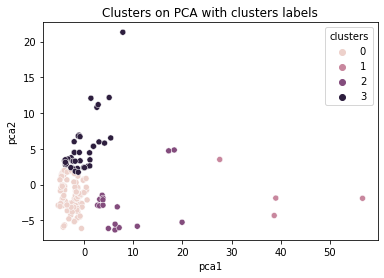

In [22]:
clustering_kmeans = KMeans(n_clusters=4)
results2['clusters'] = clustering_kmeans.fit_predict(results2)
results2['clusters']

sns.scatterplot(x="pca1", y="pca2", hue=results2['clusters'], data=results2)
plt.title('Clusters on PCA with clusters labels')
plt.show()

## Cluster before PCA

In [23]:
clustering_kmeans = KMeans(n_clusters=4)
df_mol2vec['clusters'] = clustering_kmeans.fit_predict(df_mol2vec)
df_mol2vec['clusters']

0      2
1      2
2      2
3      2
4      2
      ..
166    2
167    2
168    2
169    2
170    0
Name: clusters, Length: 171, dtype: int32

c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


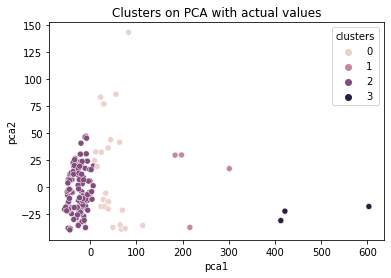

In [24]:
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(df_mol2vec)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=df_mol2vec['clusters'], data=results)
plt.title('Clusters on PCA with actual values')
plt.show()

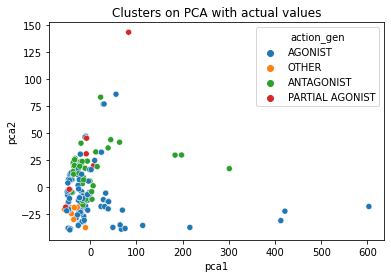

In [25]:
sns.scatterplot(x="pca1", y="pca2", hue=df['action_gen'], data=results)
plt.title('Clusters on PCA with actual values')
plt.show()

## Results comparison

In [32]:
from sklearn.metrics import classification_report

print(results2['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(results2['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

results2['action_gen'] = df['action_gen']
results2['action_gen_cluster'] = results2['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(results2.action_gen, results2.action_gen_cluster))
results2[results2.action_gen == results2.action_gen_cluster].shape[0] / results2.shape[0]
# print('Accuracy', accuracy_score(results2.action_gen, results2.action_gen_cluster))
print(classification_report(results2.action_gen, results2.action_gen_cluster))


0    107
3     43
2     17
1      4
Name: clusters, dtype: int64
pairing_score:  0.552390780873753
                 precision    recall  f1-score   support

        AGONIST       0.71      0.70      0.71       108
     ANTAGONIST       0.51      0.51      0.51        43
          OTHER       0.00      0.00      0.00         9
PARTIAL AGONIST       0.06      0.09      0.07        11

       accuracy                           0.58       171
      macro avg       0.32      0.33      0.32       171
   weighted avg       0.58      0.58      0.58       171



In [27]:
# sort keys based on number of values in each clusters
print(df_mol2vec['clusters'].value_counts())
cluster_dict = dict(df_mol2vec['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

df_mol2vec['action_gen'] = df['action_gen']
df_mol2vec['action_gen_cluster'] = df_mol2vec['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(df_mol2vec.action_gen, df_mol2vec.action_gen_cluster))
df_mol2vec[df_mol2vec.action_gen == df_mol2vec.action_gen_cluster].shape[0] / df_mol2vec.shape[0]
print('Accuracy', df_mol2vec[df_mol2vec.action_gen == df_mol2vec.action_gen_cluster].shape[0] / df_mol2vec.shape[0])

2    137
0     27
1      4
3      3
Name: clusters, dtype: int64
pairing_score:  0.47327141382868937
Accuracy 0.5321637426900585


In [28]:
df['action_gen'].value_counts()

AGONIST            108
ANTAGONIST          43
PARTIAL AGONIST     11
OTHER                9
Name: action_gen, dtype: int64